Nhóm 4T
- 1712756 Nguyễn Hữu Thắng 

In [89]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import  LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from pandas.tseries.offsets import DateOffset
from pmdarima.arima import auto_arima
import chart_studio.plotly as py
import plotly.graph_objs as go

Tải covid data tại link: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

In [3]:
covid_df=pd.read_csv('covid_19_data.csv')
covid_df.info()
covid_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77467 entries, 0 to 77466
Data columns (total 8 columns):
SNo                77467 non-null int64
ObservationDate    77467 non-null object
Province/State     51018 non-null object
Country/Region     77467 non-null object
Last Update        77467 non-null object
Confirmed          77467 non-null float64
Deaths             77467 non-null float64
Recovered          77467 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 3.5+ MB


,SNo,Confirmed,Deaths,Recovered
count,77467.000000,77467.000000,77467.000000,7.746700e+04
mean,38734.000000,11807.370881,600.764958,5.745271e+03
std,22362.940989,35795.251718,2569.398570,3.233784e+04
min,1.000000,0.000000,0.000000,0.000000e+00
25%,19367.500000,132.000000,1.000000,1.000000e+00
50%,38734.000000,1154.000000,21.000000,1.670000e+02
75%,58100.500000,6198.000000,196.000000,1.842000e+03
max,77467.000000,552318.000000,41584.000000,1.461885e+06


In [4]:
covid_df.rename(columns={'ObservationDate':'Date','Province/State':'Province',
                   'Country/Region':'Country'},inplace=True)
covid_df.loc[covid_df['Country']=='Mainland China','Country']='China'
covid_df['Date'] = pd.to_datetime(covid_df['Date'],format='%m/%d/%Y')
covid_df.head()

,SNo,Date,Province,Country,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,China,1/22/2020 17:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,China,1/22/2020 17:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,China,1/22/2020 17:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,China,1/22/2020 17:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,China,1/22/2020 17:00,0.0,0.0,0.0


Ta thấy các ca mắc đầu tiên thuộc về China

In [5]:
print("Size of the dataset: ",covid_df.shape)
print("Checking for null values:\n",covid_df.isnull().mean().sort_values(ascending=True))

Size/Shape of the dataset:  (77467, 8)
Checking for null values:
 SNo            0.000000
Date           0.000000
Country        0.000000
Last Update    0.000000
Confirmed      0.000000
Deaths         0.000000
Recovered      0.000000
Province       0.341423
dtype: float64


# Visualize data

Text(0.5, 1.0, 'Top 10 countries Confirmed')

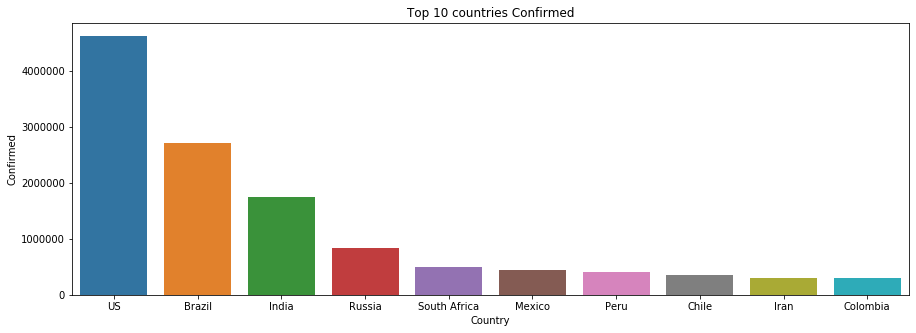

In [6]:
#top 10
#Get the top 10 countries
last_date = covid_df.Date.max()
df_countries = covid_df[covid_df['Date']==last_date]
df_countries = df_countries.groupby('Country', as_index=False)['Confirmed','Deaths'].sum()

fig = plt.figure(figsize=(15,5))
sns.barplot(x="Country", y="Confirmed", data=df_countries.nlargest(10,'Confirmed')).set_title('Top 10 countries Confirmed')

Text(0.5, 1.0, 'Top 10 countries Deaths')

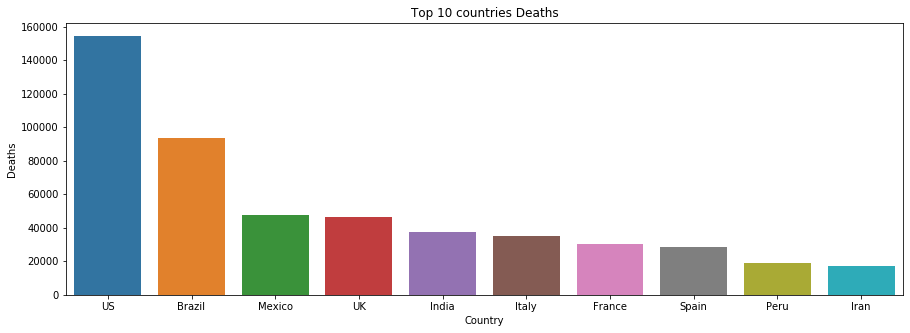

In [7]:
fig = plt.figure(figsize=(15,5))
sns.barplot(x="Country", y="Deaths", data=df_countries.nlargest(10,'Deaths')).set_title('Top 10 countries Deaths')

Ta thấy Mỹ và Brazil là 2 nước có số lượng người chết và người bị nhiễm lần lượt cao nhất nhì. Ấn Độ có số người bị nhiễm cao thứ 3 nhưng số người chết của nước này lại chỉ đứng thứ 5. Mexico không nằm trong top 10 nước có ca nhiễm cao nhất nhưng lại đứng thứ 3 về số người chết. Trong khi đó, China lại không nằm trong top 10 nước có số ca nhiễm và số ca chết nhiều nhất mặc dù đây là nơi khởi điểm của dịch. Qua đó, ta có thể thấy được 1 số nước ít quan tâm hoặc ít có các biện pháp hữu hiệu để ngăn dịch hơn các nước khác 

In [40]:
#Get the top 10 countries Confirmed
last_date = covid_df.Date.max()
df_countries = covid_df[covid_df['Date']==last_date]
df_countries = df_countries.groupby('Country', as_index=False)['Confirmed','Deaths'].sum()
df_countries = df_countries.nlargest(10,'Confirmed')
df_countries_D = df_countries.nlargest(10,'Deaths')
#trend top 10 confirmed
df_trend = covid_df.groupby(['Date','Country'], as_index=False)['Confirmed','Deaths'].sum()
df_trend = df_trend.merge(df_countries, on='Country')
df_trend['Confirmed_Cases'] = np.log(df_trend['Confirmed_x'].values+1)
df_trend_D = covid_df.groupby(['Date','Country'], as_index=False)['Confirmed','Deaths'].sum()
df_trend_D = df_trend_D.merge(df_countries, on='Country')
df_trend_D['Deaths_Cases'] = np.log(df_trend['Deaths_x'].values+1)

Text(0.5, 1.0, 'Trend top 10 countries confirmed')

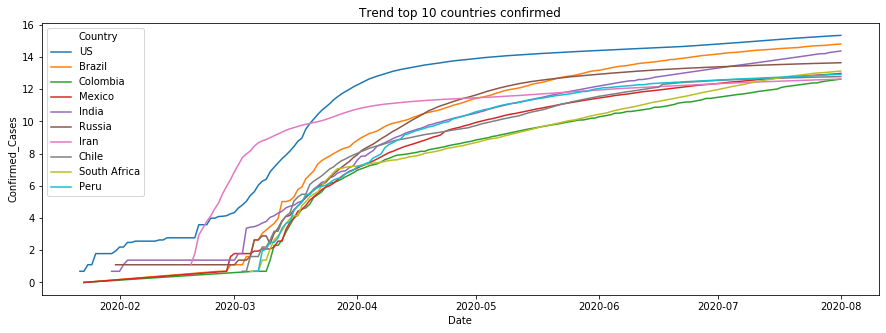

In [9]:
fig = plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='Confirmed_Cases', hue='Country',data=df_trend).set_title('Trend top 10 countries confirmed')

Qua biểu đồ, ta thấy xu hướng phát triển số ca nhiễm ở các nước lúc bắt đầu nằm gần nhau. Điều đó cho dịch lây lan rất nhanh giữa các nước. Khoảng giữa tháng 3 2020 là đỉnh điểm của sự tăng mạnh các ca nhiễm trên các nước.

Text(0.5, 1.0, 'Trend top 10 countries Deaths')

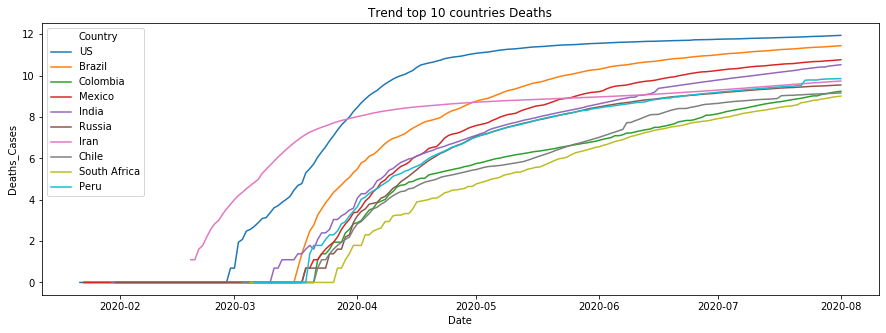

In [41]:
fig = plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='Deaths_Cases', hue='Country',data=df_trend_D).set_title('Trend top 10 countries Deaths')

Số ca tử vong tăng nhanh bắt đầu gần tháng 4 và diễn biến phức tạp. Sự xuất hiện số ca tử vong của các nước cũng khác nhau. Điều này thể hiện sự khác nhau giữa điều kiện y tế ở các nước.

In [31]:
# Read time series
confirmed_df=pd.read_csv('time_series_covid_19_confirmed.csv')
deaths_df=pd.read_csv('time_series_covid_19_deaths.csv')
recovered_df=pd.read_csv('time_series_covid_19_recovered.csv')
confirmed_df.info()
confirmed_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 197 entries, Province/State to 8/1/20
dtypes: float64(2), int64(193), object(2)
memory usage: 407.4+ KB


,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,...,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02
mean,21.076624,22.829441,2.086466,2.458647,3.537594,5.390977,7.962406,11.003759,20.969925,23.180451,...,5.831288e+04,5.936989e+04,6.033058e+04,6.110163e+04,6.198372e+04,6.293235e+04,6.401938e+04,6.505984e+04,6.613522e+04,6.710467e+04
std,24.904600,70.191330,27.279200,27.377862,34.083035,47.434934,66.289178,89.313757,219.187744,220.524977,...,3.029832e+05,3.091674e+05,3.148280e+05,3.191810e+05,3.235822e+05,3.290138e+05,3.354734e+05,3.415332e+05,3.475803e+05,3.528725e+05
min,-51.796300,-135.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.677575,-15.277675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.565000e+02,2.565000e+02,2.635000e+02,2.637500e+02,2.667500e+02,2.667500e+02,2.667500e+02,2.715000e+02,2.715000e+02,2.715000e+02
50%,22.820850,20.921188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.702000e+03,1.711500e+03,1.723000e+03,1.779000e+03,1.813000e+03,1.821500e+03,1.833000e+03,1.845000e+03,1.874500e+03,1.900000e+03
75%,41.143200,77.913685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.545100e+04,1.601425e+04,1.635575e+04,1.643000e+04,1.682950e+04,1.702700e+04,1.723075e+04,1.771675e+04,1.838550e+04,1.912900e+04
max,71.706900,178.065000,444.000000,444.000000,549.000000,761.000000,1058.000000,1423.000000,3554.000000,3554.000000,...,4.038816e+06,4.112531e+06,4.178970e+06,4.233923e+06,4.290337e+06,4.356206e+06,4.426982e+06,4.495015e+06,4.562038e+06,4.620444e+06


# Tiền xử lý dữ liệu (Data preprocessing)

In [32]:
confirmed_df = confirmed_df.drop(labels=['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
confirmed_df = confirmed_df.T
confirmed_df['Confirmed_case'] = confirmed_df.sum(axis=1)
confirmed_df = confirmed_df['Confirmed_case']

deaths_df = deaths_df.drop(labels=['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
deaths_df = deaths_df.T
deaths_df['Deaths_case'] = deaths_df.sum(axis=1)
deaths_df = deaths_df['Deaths_case']

recovered_df = recovered_df.drop(labels=['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
recovered_df = recovered_df.T
recovered_df['Recovered_case'] = recovered_df.sum(axis=1)
recovered_df = recovered_df['Recovered_case']

# Model Time series (SARIMA)

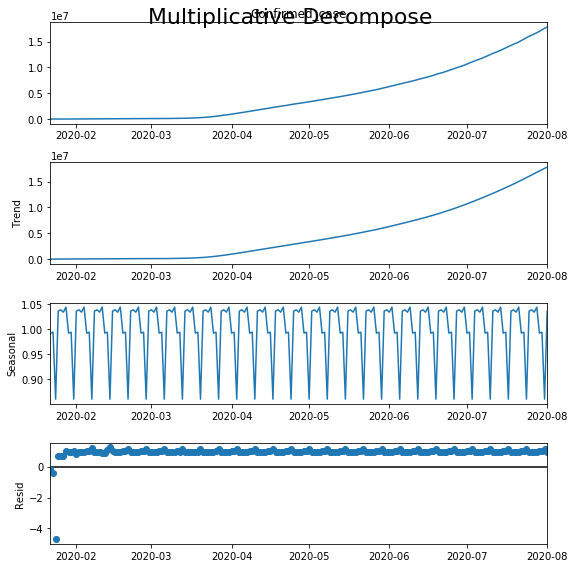

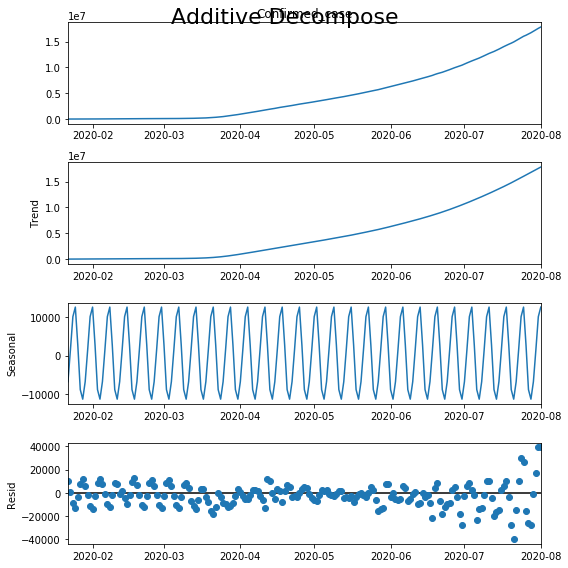

In [33]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(confirmed_df.asfreq('d'), model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(confirmed_df.asfreq('d'), model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul.plot().suptitle('Multiplicative Decompose Confirmed', fontsize=22)
result_add.plot().suptitle('Additive Decompose Confirmed', fontsize=22)
plt.show()

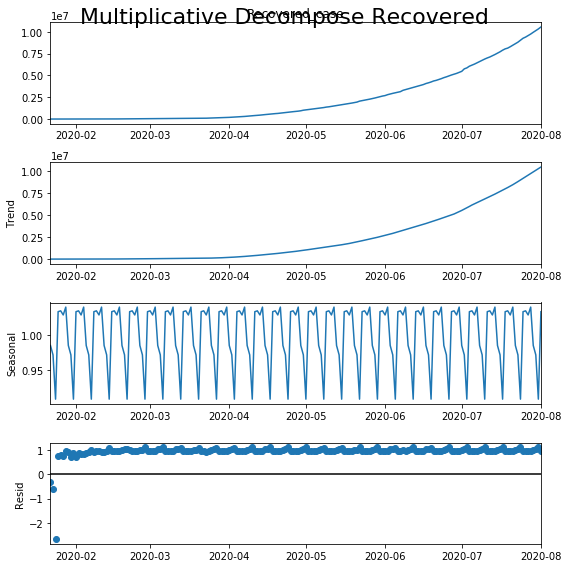

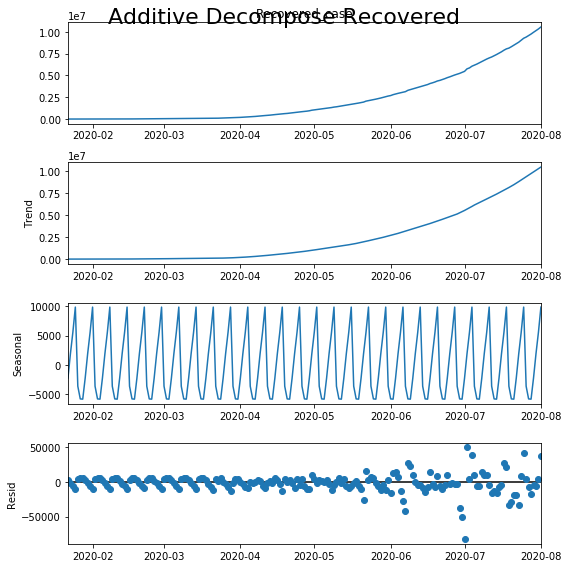

In [37]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(recovered_df.asfreq('d'), model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(recovered_df.asfreq('d'), model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul.plot().suptitle('Multiplicative Decompose Recovered', fontsize=22)
result_add.plot().suptitle('Additive Decompose Recovered', fontsize=22)
plt.show()

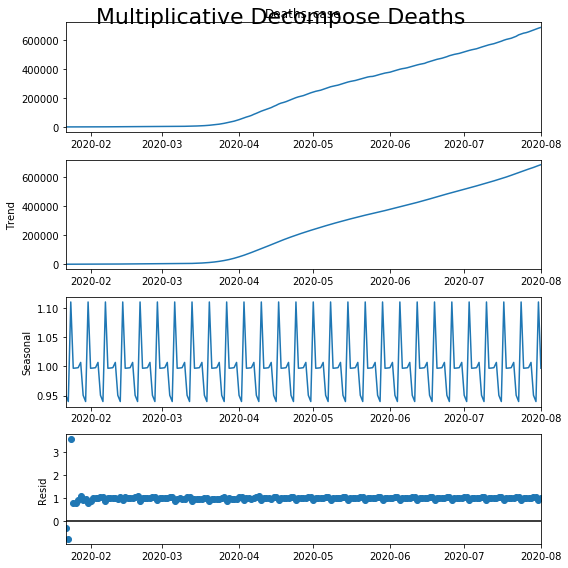

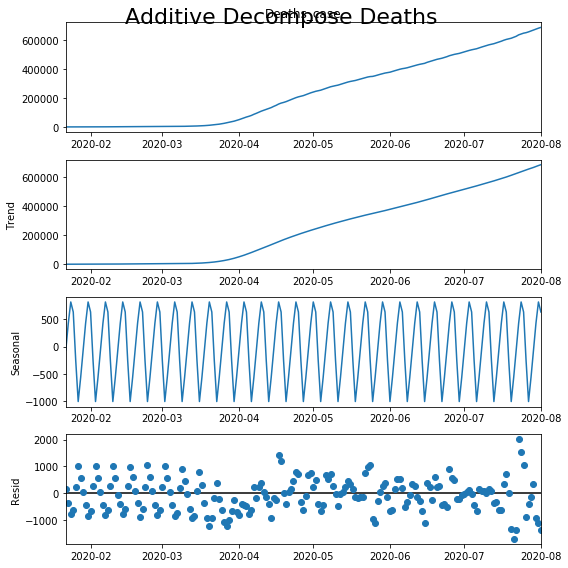

In [38]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(deaths_df.asfreq('d'), model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(deaths_df.asfreq('d'), model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul.plot().suptitle('Multiplicative Decompose Deaths ', fontsize=22)
result_add.plot().suptitle('Additive Decompose Deaths ', fontsize=22)
plt.show()

In [45]:
C_model = auto_arima(confirmed_df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(C_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.66 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4204.192, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4000.216, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4094.231, Time=1.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4018.512, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3974.072, Time=3.76 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=3958.409, Time=20.70 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=8.54 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=3959.355, Time=14.30 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=3964.428, Time=13.21 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=4158.481, Time=15.12 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=3958.888, Time=9.00 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=3956.522, Time=8.43 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3966.427, Time=2.16 sec
 ARIMA(1,1,1)(2,1,0)[12] 

In [46]:
C_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  193
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 12)   Log Likelihood               -1924.236
Date:                              Sat, 15 Aug 2020   AIC                           3864.471
Time:                                      20:25:22   BIC                           3890.015
Sample:                                           0   HQIC                          3874.828
                                              - 193                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2406      0.029     76.589      0.000       2.183       2.298
ar.L2         -2.2405      0.050    -44.382      0.000      -2.339      -2.142
ar.L3          1.0000      0.032     31.697      0.000       0.938       1.062
ma.L1         -1.7543      0.167    -10.531      0.000      -2.081      -1.428
ma.L2          1.4732      0.242      6.093      0.000       0.999       1.947
ma.L3         -0.4186      0.172     -2.438      0.015      -0.755      -0.082
ma.S.L12      -0.7518      0.141     -5.335      0.000      -1.028      -0.476
sigma2       1.93e+08   4.68e-10   4.13e+17      0.000    1.93e+08    1.93e+08
===================================================================================
Ljung-Box (Q):                      134.79   Jarque-Bera (JB):                22.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.31   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+34. Standard errors may be unstable.
"""

In [35]:
# Deaths_df
D_model = auto_arima(deaths_df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(D_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.00 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3207.058, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3078.074, Time=2.65 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3119.284, Time=1.98 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3106.230, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3042.142, Time=8.33 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=13.96 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=8.52 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3196.468, Time=4.82 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3042.619, Time=11.59 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=3036.899, Time=11.47 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3076.168, Time=2.29 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=12.71 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.35 sec
 ARIMA(0,1,1)(2,1,0)[12]             : A

In [47]:
D_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  193
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -1486.234
Date:                              Sat, 15 Aug 2020   AIC                           2986.468
Time:                                      20:25:29   BIC                           3008.819
Sample:                                           0   HQIC                          2995.530
                                              - 193                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    500.817      0.000       0.996       1.004
ma.L1         -0.3570      0.064     -5.577      0.000      -0.482      -0.232
ma.L2         -0.2164      0.068     -3.188      0.001      -0.349      -0.083
ar.S.L12      -0.2630      0.078     -3.363      0.001      -0.416      -0.110
ar.S.L24      -0.4140      0.094     -4.428      0.000      -0.597      -0.231
ma.S.L12      -0.8614      0.077    -11.186      0.000      -1.012      -0.710
sigma2       7.64e+05   5.72e-08   1.34e+13      0.000    7.64e+05    7.64e+05
===================================================================================
Ljung-Box (Q):                      241.59   Jarque-Bera (JB):                50.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.31   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.07e+28. Standard errors may be unstable.
"""

In [36]:
#recovered_df
R_model = auto_arima(recovered_df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(R_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4113.539, Time=8.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4238.394, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4200.130, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4224.828, Time=0.81 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4199.828, Time=0.71 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=4115.977, Time=8.99 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=4113.674, Time=23.52 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4139.503, Time=7.72 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=26.14 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4206.846, Time=1.02 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=4140.405, Time=4.40 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=4143.513, Time=5.86 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4236.150, Time=0.33 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=4197.534, Time=1.14 sec
 ARIMA(2,1,0)(0,1,1)[1

In [48]:
R_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  193
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2052.770
Date:                            Sat, 15 Aug 2020   AIC                           4113.539
Time:                                    20:25:36   BIC                           4126.311
Sample:                                         0   HQIC                          4118.718
                                            - 193                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.003    311.466      0.000       0.994       1.006
ma.L1         -0.8282      0.038    -21.733      0.000      -0.903      -0.753
ma.S.L12      -0.8830      0.034    -26.056      0.000      -0.949      -0.817
sigma2      4.399e+08   4.11e-11   1.07e+19      0.000     4.4e+08     4.4e+08
===================================================================================
Ljung-Box (Q):                       54.37   Jarque-Bera (JB):              4203.28
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):             231.37   Skew:                             3.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.83e+33. Standard errors may be unstable.
"""

In [43]:
# split data
size_C = int(len(confirmed_df) * 0.9)
train_C, test_C = confirmed_df[0:size_C], confirmed_df[size_C:]
size_D = int(len(deaths_df) * 0.9)
train_D, test_D = deaths_df[0:size_D], deaths_df[size_D:]
size_R = int(len(recovered_df) * 0.9)
train_R, test_R = recovered_df[0:size_R], recovered_df[size_R:]
print('Confirmed:',len(train_C),len(test_C))
print('Deaths:',len(train_D),len(test_D))
print('Recovered:',len(train_R),len(test_R))

Confirmed: 173 20
Deaths: 173 20
Recovered: 173 20


In [64]:
# Train
C_model.fit(train_C)
D_model.fit(train_D)
R_model.fit(train_R)
# Dự đoán kết quả 20 ngày sau
future_forecast_C= C_model.predict(n_periods=20)
future_forecast_D= D_model.predict(n_periods=20)
future_forecast_R= R_model.predict(n_periods=20)
print(future_forecast_C)

[13129128.81127437 13349328.87329847 13585911.84294885 13831267.6420333
 14075973.31618938 14294540.26767861 14511747.53189166 14734057.58960048
 14971165.54827946 15228132.08531672 15488136.69705654 15736532.7002206
 15985764.78606375 16216506.21157171 16450704.60739464 16702383.32165817
 16977094.34786496 17246262.19553386 17515888.96446956 17772294.86795897]


In [100]:
print(future_forecast_D)

[573177.74620641 578236.23564606 583326.7276366  588658.61864512
 593673.86537908 598486.60211731 602758.97363675 607703.4328199
 612869.29383927 618732.1400512  624200.97846056 628983.00174539
 634173.28739708 639281.85700194 644336.94544275 649538.93785188
 655210.3953763  660652.36026485 665799.43773912 670985.00003374
 676212.48806507 681545.52160773 686831.10468937 692180.29129849
 697785.81251029 703238.37791958 708600.65122879 713834.60041512
 719173.56609677 724477.57747222 730405.72468259 736002.21040998
 741648.14052942 747230.30621546 752687.95317347 757975.49933227
 763483.02094171 769181.13327323 774825.16036487 780427.45740216]


In [101]:
print(future_forecast_R)

[ 7255691.48425482  7485590.60538896  7620928.06650016  7797950.1755825
  7947144.00134956  8100129.56285177  8255958.98708341  8422692.72436765
  8580926.81299333  8736692.66739275  8890974.84726653  9040419.84108248
  9200713.49493356  9452067.78566391  9608860.41637129  9807337.69504976
  9977986.69041291 10152427.42151118 10329712.01533883 10517900.92221904
 10697590.18044064 10874811.20443595 11050548.55390557 11221448.71731733
 11403197.54076417 11676007.00109024 11854254.8013933  12074187.24966741
 12266291.41462616 12462187.31531999 12660927.07874315 12870571.15521883
 13071715.58303587 13270391.77662657 13467584.29569155 13659939.62869861
 13863143.62174072 14157408.25166202 14357111.22156027 14598498.83942952]


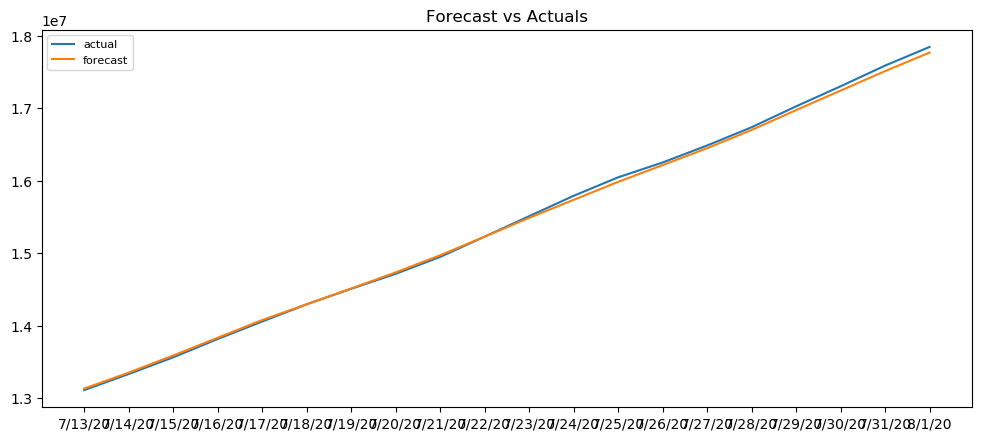

In [66]:
future_forecast_C = pd.DataFrame(future_forecast_C,index=test_C.index,columns=['Prediction'])
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_C, label='test')
plt.plot(future_forecast_C, label='forecast')
plt.title('Forecast vs Test')
plt.legend(loc='upper left', fontsize=8)
plt.show()

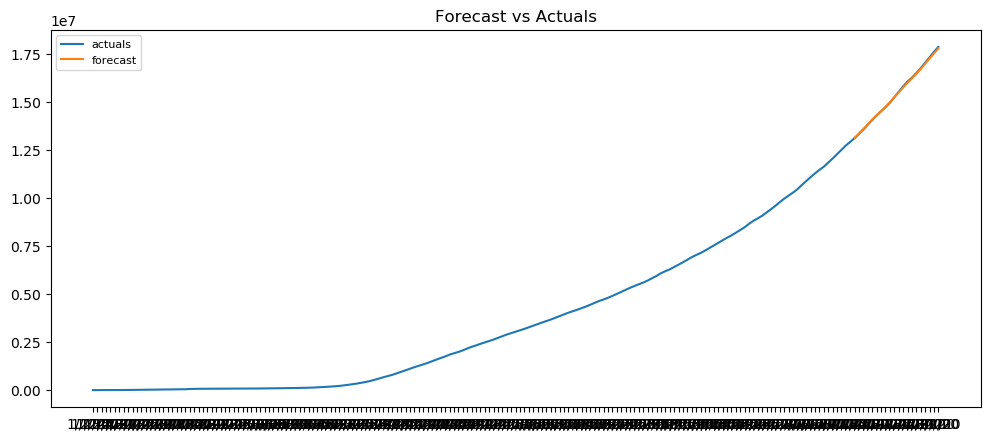

In [67]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(confirmed_df, label='actuals')
plt.plot(future_forecast_C, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

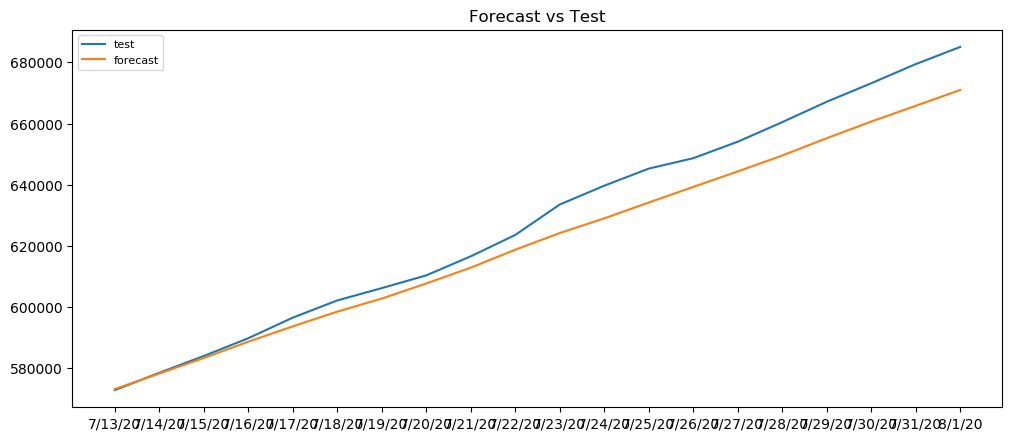

In [68]:
future_forecast_D = pd.DataFrame(future_forecast_D,index=test_D.index,columns=['Prediction'])
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_D, label='test')
plt.plot(future_forecast_D, label='forecast')
plt.title('Forecast vs Test')
plt.legend(loc='upper left', fontsize=8)
plt.show()

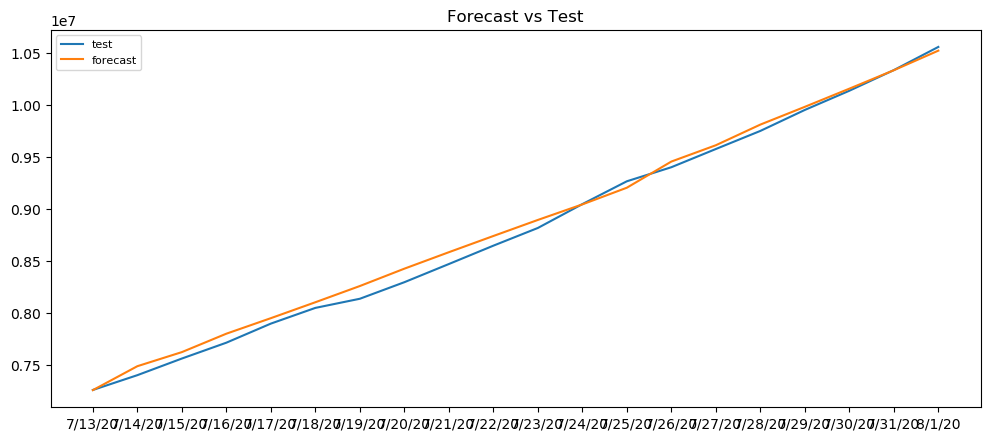

In [69]:
future_forecast_R = pd.DataFrame(future_forecast_R,index=test_R.index,columns=['Prediction'])
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_R, label='test')
plt.plot(future_forecast_R, label='forecast')
plt.title('Forecast vs Test')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [77]:
C_model.fit(train_C)
D_model.fit(train_D)
R_model.fit(train_R)
# Dự đoán kết quả 20 ngày sau test
future_forecast_C_40= C_model.predict(n_periods=40)
future_forecast_D_40= D_model.predict(n_periods=40)
future_forecast_R_40= R_model.predict(n_periods=40)

In [80]:
future_forecast_C_40 = pd.DataFrame(future_forecast_C[20:].astype(int),columns=['Prediction'])
print(future_forecast_C_40)


    Prediction
0     18019016
1     18273618
2     18540897
3     18820454
4     19120767
5     19403367
6     19670488
7     19930889
8     20203305
9     20480724
10    20782650
11    21090569
12    21388547
13    21674894
14    21950041
15    22227423
16    22536987
17    22853005
18    23172022
19    23483037


In [83]:
future_forecast_D_40 = pd.DataFrame(future_forecast_D[20:].astype(int),columns=['Prediction'])
print(future_forecast_D_40)


    Prediction
0       676212
1       681545
2       686831
3       692180
4       697785
5       703238
6       708600
7       713834
8       719173
9       724477
10      730405
11      736002
12      741648
13      747230
14      752687
15      757975
16      763483
17      769181
18      774825
19      780427


In [84]:
future_forecast_R_40 = pd.DataFrame(future_forecast_R[20:].astype(int),columns=['Prediction'])
print(future_forecast_R_40)


    Prediction
0     10697590
1     10874811
2     11050548
3     11221448
4     11403197
5     11676007
6     11854254
7     12074187
8     12266291
9     12462187
10    12660927
11    12870571
12    13071715
13    13270391
14    13467584
15    13659939
16    13863143
17    14157408
18    14357111
19    14598498


In [87]:
covid_df.tail()

,SNo,Date,Province,Country,Last Update,Confirmed,Deaths,Recovered
77462,77463,2020-08-01,Zaporizhia Oblast,Ukraine,2020-08-02 04:34:47,800.0,21.0,597.0
77463,77464,2020-08-01,Zeeland,Netherlands,2020-08-02 04:34:47,867.0,69.0,0.0
77464,77465,2020-08-01,Zhejiang,China,2020-08-02 04:34:47,1270.0,1.0,1268.0
77465,77466,2020-08-01,Zhytomyr Oblast,Ukraine,2020-08-02 04:34:47,1896.0,37.0,1485.0
77466,77467,2020-08-01,Zuid-Holland,Netherlands,2020-08-02 04:34:47,13262.0,1311.0,0.0


Ta thấy sau ngày 01/08/2020 tiếp theo 20 ngày sau xu hướng của bệnh dịch vẫn chưa giảm và tiếp tục phát triển mặc dù nó có phần đã được kìm hãm nhiều so với trước. Dự đoán kết quả ngày 02/08/2020 có số người bị nhiễm là: 18019016 (tăng thêm 169173 người ,giảm so với mức 257875 người của ngày trước đó), số người chết là: 676212 (kết quả này thấp hơn so với thực tế), số ca khỏi bệnh là: 10697590 (tăng thêm 144005 người). 

Tài liệu tham khảo: 
- https://www.kaggle.com/jinghuiwong/arima-eda-with-map-visualization
- https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
- https://www.kaggle.com/zdeutsch/arima-forecast-for-coronavirus-confirmed-cases-vol
- https://www.kaggle.com/khoongweihao/covid-19-novel-coronavirus-eda-forecasting-cases